In [1]:
import argparse
import pickle
from pathlib import Path

import fraud_eagle as feagle
import fraudar
import networkx as nx
import numpy as np
import pandas as pd
import rsd

from rev2 import rev2compute
from utils import load_data, split_data_by_time

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

In [6]:
def get_results(data_name="alpha", alg="fraudar", attack_name="sockfarm_attack", budget=100.0):
    data_nw_df, data_gt_df = load_data(data_name=data_name)
    p = Path(f"../res/{attack_name}/{alg}-{data_name}/{budget}.pkl")
    if not p.exists():
        return None
    with open(p, "rb") as fp:
        scores = pickle.load(fp)
        scores = dict(zip(range(len(scores)), scores))
        # 1 means fraudster, 0 means benign
        scores["truth"] = dict(zip(data_gt_df["id"], (1-data_gt_df["label"])/2))
    df = pd.DataFrame({sp: {u: scores[sp][u] for u in scores[sp] if u in data_gt_df["id"].tolist()} for sp in scores})
    # higher score means fraudster
    if alg in ["rev2"]:
        df[list(range(len(scores)-1))] = -df[list(range(len(scores)-1))]
    return df

In [3]:
def get_metrics(df_res, splits=4, K=None):
    if df_res is None:
        return None
    ret = {}
    for sp in range(splits):
        df_res["truth"] = df_res["truth"].fillna(1)
        df = df_res[[sp, "truth"]].dropna()
        t = df["truth"].sum() if K is None else K
        df["pred"] = (df[sp].rank(ascending=False, method="min") <= t) * 1

        ret[sp] = {
            "precision": sklearn.metrics.precision_score(y_true=df["truth"], y_pred=df["pred"]),
            "recall": sklearn.metrics.recall_score(y_true=df["truth"], y_pred=df["pred"]),
            "f1": sklearn.metrics.f1_score(y_true=df["truth"], y_pred=df["pred"])
        }
    return ret

In [4]:
alg_list = ["fraudar", "rsd", "rev2"][:2]
data_list = ["alpha", "otc", "amazon", "epinions"][:1]

In [7]:
attack_res = {
    (d, a): get_results(data_name=d, alg=a, attack_name="sockfarm_attack", budget=100.0)
    for d in data_list for a in alg_list
}
dict_met = {
    (d, a): pd.DataFrame.from_dict(get_metrics(df_res=attack_res[(d, a)], splits=4, K=None))
    for d, a in attack_res
}
df_met = pd.concat(dict_met, keys=dict_met.keys())
display(df_met)

0         1         2         3
alpha fraudar precision  0.354167  0.354167  0.354167  0.354167
              recall     0.894737  0.894737  0.894737  0.894737
              f1         0.507463  0.507463  0.507463  0.507463
      rsd     precision  0.354167  0.354167  0.354167  0.354167
              recall     0.894737  0.894737  0.894737  0.894737
              f1         0.507463  0.507463  0.507463  0.507463

In [9]:
df_met.mean(axis=1).to_frame()

0
alpha fraudar precision  0.354167
              recall     0.894737
              f1         0.507463
      rsd     precision  0.354167
              recall     0.894737
              f1         0.507463

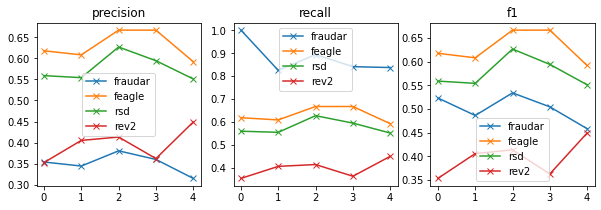

In [9]:
data_name = "alpha"
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    m = ["precision", "recall", "f1"][i]
    df_plot = df_met.loc[(data_name, slice(None), m)]
    df_plot.T.plot(ax=axes[i], marker="x", title=m)

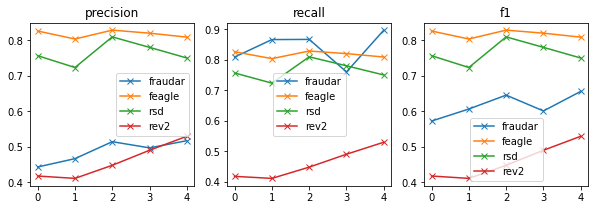

In [10]:
data_name = "otc"
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    m = ["precision", "recall", "f1"][i]
    df_plot = df_met.loc[(data_name, slice(None), m)]
    df_plot.T.plot(ax=axes[i], marker="x", title=m)

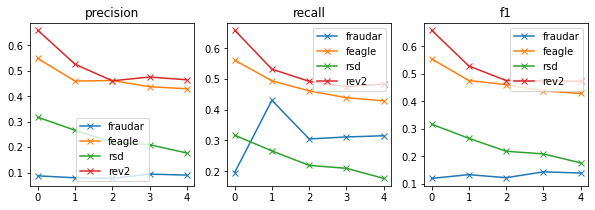

In [11]:
data_name = "amazon"
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    m = ["precision", "recall", "f1"][i]
    df_plot = df_met.loc[(data_name, slice(None), m)]
    df_plot.T.plot(ax=axes[i], marker="x", title=m)

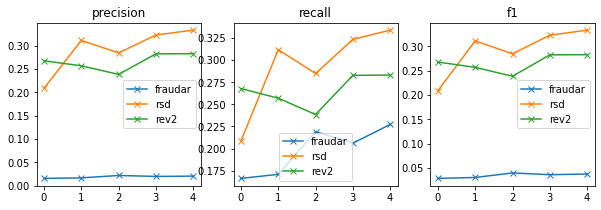

In [12]:
data_name = "epinions"
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    m = ["precision", "recall", "f1"][i]
    df_plot = df_met.loc[(data_name, slice(None), m)]
    df_plot.T.plot(ax=axes[i], marker="x", title=m)